 __Project - Wine classification__

1. [Import](#Import)
    1. [Tools](#Tools)
    1. [Data](#Data)    
1. [EDA](#EDA)
    1. [Continuous feature EDA](#Continuous-feature-EDA)
    1. [Faceting](#Faceting)
    1. [Target variable evaluation](#Target-variable-evaluation)    
1. [Data preparation](#Data-preparation)
    1. [Missing data](#Missing-data)
    1. [Feature engineering](#Feature-engineering)
        1. [Handcrafted](#Handcrafted)
        1. [Polynomial features](#Polynomial-features)
    1. [Feature transformation](#Feature-transformation)
        1. [Skew correction](#Skew-correction)
        1. [Scaling](#Scaling)     
    1. [Outliers](#Outliers)
    1. [Additional exploratory data analysis](#Additional-exploratory-data-analysis)
1. [Feature importance](#Feature-importance)    
1. [Modeling](#Modeling)
    1. [Data preparation](#Data-preparation-1)
    1. [Bayesian hyper-parameter optimization](#Bayesian-hyper-parameter-optimization)
    1. [Model performance evaluation - standard models](#Model-performance-evaluation-standard-models)
    1. [Validation set evaluation - standard models](#Validation-set-evaluation-standard-models)
    1. [Model explanability](#Model-explanability)
1. [Stacking](#Stacking)
    1. [Primary models](#Primary-models)
    1. [Meta model](#Meta-model)                
    1. [Model performance evaluation - stacked models](#Model-performance-evaluation-stacked-models)
    1. [Validation set evaluation - stacked models](#Validation-set-evaluation-stacked-models)


# Import

<a id = 'Import'></a>

## Tools

<a id = 'Tools'></a>

In [1]:
# standard libary and settings
import copy
import os
import sys
import importlib
import itertools
from functools import reduce
import time; rundate = time.strftime("%Y%m%d")

import warnings
warnings.simplefilter("ignore")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np
np.set_printoptions(threshold=np.inf, suppress=True)

import pandas as pd
pd.set_option("display.max_rows", 500); pd.set_option("display.max_columns", 500)
pd.options.display.float_format = "{:,.6f}".format

# modeling extensions
import sklearn.base as base
import sklearn.datasets as datasets
import sklearn.ensemble as ensemble
import sklearn.impute as impute
import sklearn.linear_model as linear_model
import sklearn.model_selection as model_selection
import sklearn.neighbors as neighbors
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
import sklearn.svm as svm
import category_encoders as ce

import lightgbm
import xgboost

from hyperopt import hp

import eif
import shap
shap.initjs()

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import squarify

%matplotlib inline

try:
    #     import mlmachine as mlm
    #     from prettierplot.plotter import PrettierPlot
    #     import prettierplot.style as style
    import asdfasd
except ModuleNotFoundError:
    sys.path.append(
        "../../../mlmachine"
    ) if "../../../../mlmachine" not in sys.path else None
    sys.path.append(
        "../../../prettierplot"
    ) if "../../../../prettierplot" not in sys.path else None

    import mlmachine as mlm
    import mlmachine.data as data
    from mlmachine.features.preprocessing import (
        DataFrameSelector,
        PandasPipeline,
        KFoldSelectEncoder,
        ContextImputer,
        PandasFeatureUnion,
        DualTransformer,
    )
    from prettierplot.plotter import PrettierPlot
    import prettierplot.style as style
else:
    print(
        "This notebook relies on the libraries mlmachine and prettierplot. Please run:"
    )
    print("\tpip install mlmachine")
    print("\tpip install prettierplot")

## Data

<a id = 'Data'></a>

In [2]:
# load and inspect data
dataset = datasets.load_wine()
dataset = pd.merge(pd.DataFrame(dataset.data, columns=dataset.feature_names), pd.Series(dataset.target, name="Class label"), left_index=True, right_index=True)

print("Training data dimensions: {}".format(dataset.shape))

Training data dimensions: (178, 14)


In [3]:
# display info and first 5 rows
dataset.info()
display(dataset[:5])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  Class

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Class label
0,14.230000,1.710000,2.430000,15.600000,127.000000,2.800000,3.060000,0.280000,2.290000,5.640000,1.040000,3.920000,"1,065.000000",0
1,13.200000,1.780000,2.140000,11.200000,100.000000,2.650000,2.760000,0.260000,1.280000,4.380000,1.050000,3.400000,"1,050.000000",0
2,13.160000,2.360000,2.670000,18.600000,101.000000,2.800000,3.240000,0.300000,2.810000,5.680000,1.030000,3.170000,"1,185.000000",0
3,14.370000,1.950000,2.500000,16.800000,113.000000,3.850000,3.490000,0.240000,2.180000,7.800000,0.860000,3.450000,"1,480.000000",0
4,13.240000,2.590000,2.870000,21.000000,118.000000,2.800000,2.690000,0.390000,1.820000,4.320000,1.040000,2.930000,735.000000,0


In [4]:
# review counts of different column types
dataset.dtypes.value_counts()

float64    13
int64       1
dtype: int64

In [5]:
# split dataset into train and validation datasets
df_train, df_valid = mlm.train_test_df_compile(data=dataset, target_col='Class label')

In [6]:
# Load training data into mlmachine
train = mlm.Machine(
    data=df_train,
    identify_as_continuous=['magnesium', 'proline'],
    target="Class label",
    target_type="category",
)

>>> category label encoding

	0 --> 0
	1 --> 1
	2 --> 2



In [7]:
# Load test data into mlmachine
valid = mlm.Machine(
    data=df_valid,
    identify_as_continuous=['magnesium', 'proline'],
    target="Class label",
)

>>> category label encoding

	0 --> 0
	1 --> 1
	2 --> 2



# EDA

<a id = 'EDA'></a>

## Continuous feature EDA

<a id = 'Continuous-feature-EDA'></a>

In [8]:
# continuous features
for feature in train.data.mlm_dtypes["continuous"]:
    train.eda_cat_target_num_feat(
        feature=feature,
        outliers_out_of_scope=5,
        chart_scale=12
    )

##### Correlation

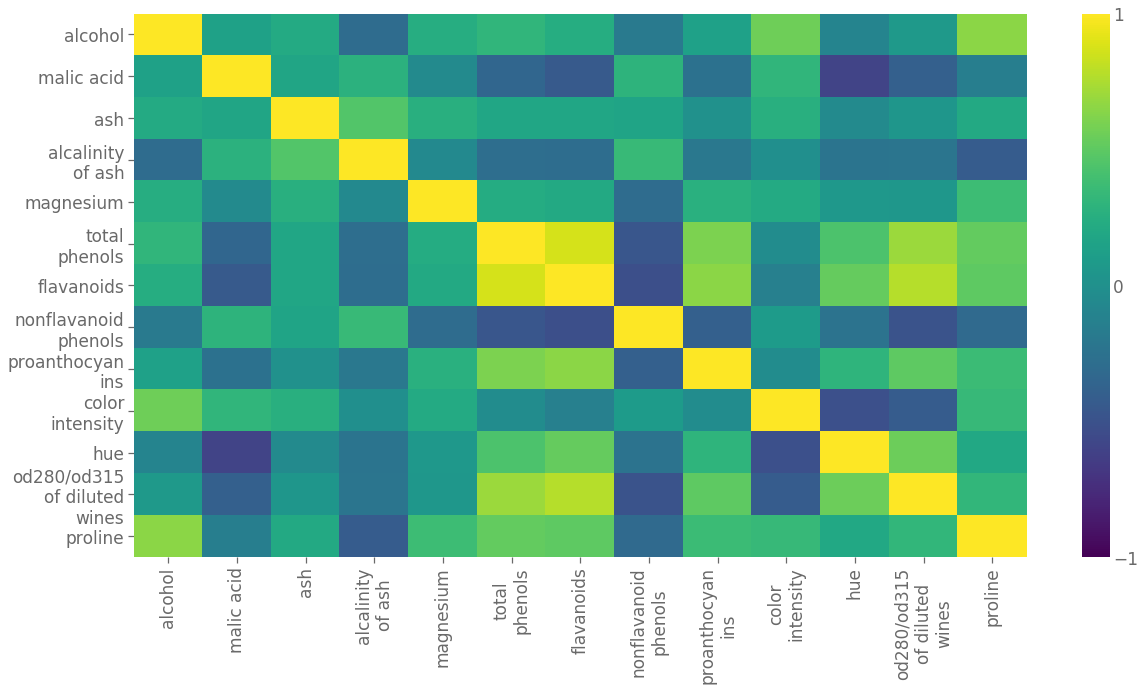

In [9]:
# correlation heat map
p = PrettierPlot(chart_scale=20)
ax = p.make_canvas()
p.corr_heatmap(df=train.data, annot=False, ax=ax)

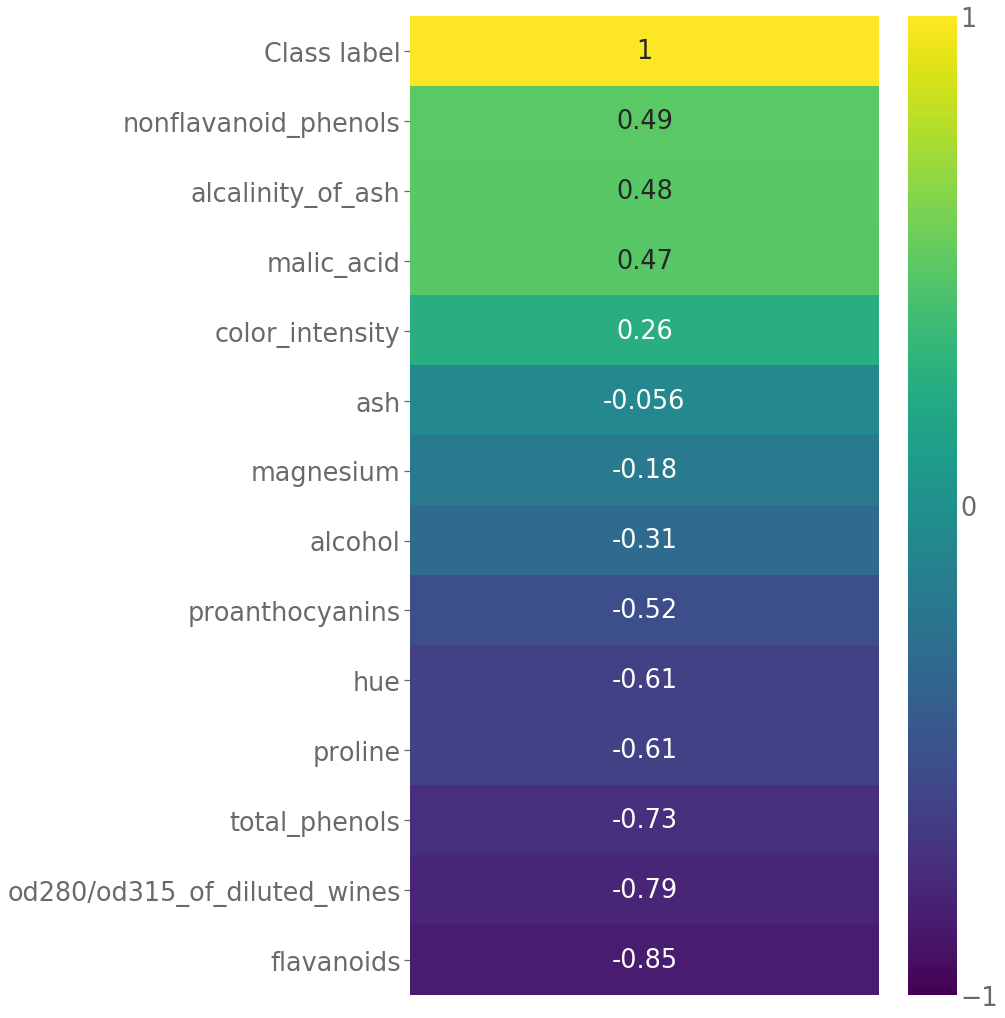

In [10]:
# correlation heat map with most highly correlated features relative to the target
p = PrettierPlot(plot_orientation='tall')
ax = p.make_canvas()
p.corr_heatmap_target(
    df=train.data, target=train.target, thresh=0.02, annot=True, ax=ax
)

##### Pair plot

In [11]:
# # pair plot
# p = PrettierPlot(chart_scale=12)
# p.pair_plot(
#     df=train.data,
#     columns=train.data.mlm_dtypes['continuous'],
#     diag_kind="auto",
# )

In [12]:
# # pair plot
# p = PrettierPlot(chart_scale=12)
# p.pair_plot(
#     df=train.data.dropna(),
#     diag_kind="kde",
#     target=train.target,
#     columns=train.data.mlm_dtypes['continuous'][:15],
#     bbox=(2.0, 0.0),
# )

## Faceting

<a id = 'Faceting'></a>

## Target variable evaluation

<a id = 'Target-variable-evaluation'></a>

In [13]:
# null score
pd.Series(train.target).value_counts(normalize=True)

1   0.401408
0   0.330986
2   0.267606
Name: Class label, dtype: float64

# Data preparation

<a id = 'Data-preparation'></a>

## Missing data

No missing data


<a id = 'Missing-data'></a>

##### Training

In [14]:
# evaluate missing data
train.eda_missing_summary()

no nulls


##### Validation

In [15]:
# evaluate missing data
valid.eda_missing_summary()

no nulls


##### Impute

## Feature engineering

<a id = 'Feature-engineering'></a>

### Handcrafted

<a id = 'Handcrafted'></a>

### Polynomial features

<a id = 'Polynomial-features'></a>

In [16]:
# transform pipe
polynomial_pipe = PandasFeatureUnion([
    ("polynomial", pipeline.make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["continuous"]),
        PandasPipeline(preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    )),
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["continuous"], exclude_columns=["Name","Cabin"]),
    )),
])

train.data = polynomial_pipe.fit_transform(train.data)
valid.data = polynomial_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

## Feature transformation

<a id = 'Transformation'></a>

### Skew correction

<a id = 'Skew-correction'></a>

In [17]:
# evaluate skew of number features - training data
train.skew_summary()

,skew,pct_zero
alcohol*ash,-0.333656,0.000000
od280/od315_of_diluted_wines,-0.283981,0.000000
hue*od280/od315_of_diluted_wines,-0.211335,0.000000
ash,-0.174961,0.000000
alcohol,-0.094666,0.000000
alcohol*od280/od315_of_diluted_wines,-0.027740,0.000000
alcohol^2,0.006293,0.000000
alcohol*hue,0.032523,0.000000
od280/od315_of_diluted_wines^2,0.058926,0.000000
hue,0.083966,0.000000


In [18]:
# evaluate skew of number features - validation data
valid.skew_summary()

,skew,pct_zero
ash,-0.479262,0.000000
hue*od280/od315_of_diluted_wines,-0.461887,0.000000
od280/od315_of_diluted_wines,-0.404379,0.000000
total_phenols,-0.361678,0.000000
flavanoids,-0.346279,0.000000
nonflavanoid_phenols*od280/od315_of_diluted_wines,-0.320514,0.000000
hue*total_phenols,-0.319868,0.000000
alcohol*hue,-0.277417,0.000000
alcalinity_of_ash*flavanoids,-0.277122,0.000000
od280/od315_of_diluted_wines*total_phenols,-0.270286,0.000000


In [19]:
# skew correction pipeline
skew_pipe = PandasFeatureUnion([
    ("skew", pipeline.make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["continuous"]),
        DualTransformer(),
    )),    
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["continuous"]),
    )),
])

train.data = skew_pipe.fit_transform(train.data)
valid.data = skew_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

### Scaling

<a id = 'Scaling'></a>

In [20]:
#
scale_pipe = PandasFeatureUnion([
    ("scale", pipeline.make_pipeline(
        DataFrameSelector(),
        PandasPipeline(preprocessing.RobustScaler())
    )),
])

train.data = scale_pipe.fit_transform(train.data)
valid.data = scale_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

## Outliers


<a id = 'Outliers'></a>

In [21]:
# identify outliers using IQR
train_pipe = pipeline.Pipeline([
    ("outlier",train.OutlierIQR(
                outlier_count=5,
                iqr_step=1.5,
                features=train.data.mlm_dtypes["continuous"],
                drop_outliers=False,))
    ])
train.data = train_pipe.transform(train.data)

# capture outliers
iqr_outliers = np.array(sorted(train_pipe.named_steps["outlier"].outliers))
print(iqr_outliers)

[ 14  18  25  59  73  95 110 121 124 137 155 159 166 173 175]


In [22]:
# identify outliers using Isolation Forest
clf = ensemble.IsolationForest(
    behaviour="new", max_samples=train.data.shape[0], random_state=0, contamination=0.01
)
clf.fit(train.data[train.data.columns])
preds = clf.predict(train.data[train.data.columns])

# evaluate index values
mask = np.isin(preds, -1)
if_outliers = np.array(train.data[mask].index)
print(if_outliers)

[ 59 121]


In [23]:
# identify outliers using extended isolation forest
train_pipe = pipeline.Pipeline([
    ("outlier",train.ExtendedIsoForest(
                columns=train.data.mlm_dtypes["continuous"],
                n_trees=100,
                sample_size=int(np.ceil(train.data.shape[0] * .25)),
                extension_level=1,
                anomalies_ratio=0.03,
                drop_outliers=False,))
    ])
train.data = train_pipe.transform(train.data)

# capture outliers
eif_outliers = np.array(sorted(train_pipe.named_steps["outlier"].outliers))
print(eif_outliers)

[ 14  25  59  73 121]


In [24]:
# identify outliers that are identified in multiple algorithms
outliers = reduce(np.intersect1d, (iqr_outliers, if_outliers, eif_outliers))
# outliers = reduce(np.intersect1d, (if_outliers, eif_outliers))
print(outliers)

[ 59 121]


In [25]:
# review outlier identification summary
outlier_summary = train.outlier_summary(iqr_outliers=iqr_outliers,
                             if_outliers=if_outliers,
                             eif_outliers=eif_outliers
                            )
outlier_summary[outlier_summary["count"] >= 3]

,iqr,if,eif,count
59,x,x,x,3
121,x,x,x,3


In [26]:
# remove outlers from predictors and response
outliers = np.array([59,121])
train.data = train.data.drop(outliers)
train.target = train.target.drop(index=outliers)

## Additional exploratory data analysis

<a id = 'Additional-exploratory-data-analysis'></a>

In [27]:
# number features
for feature in train.data.mlm_dtypes["category"][:1]:
    train.eda_cat_target_cat_feat(
        feature=feature,
        level_count_cap=10,
        chart_scale=15
    )

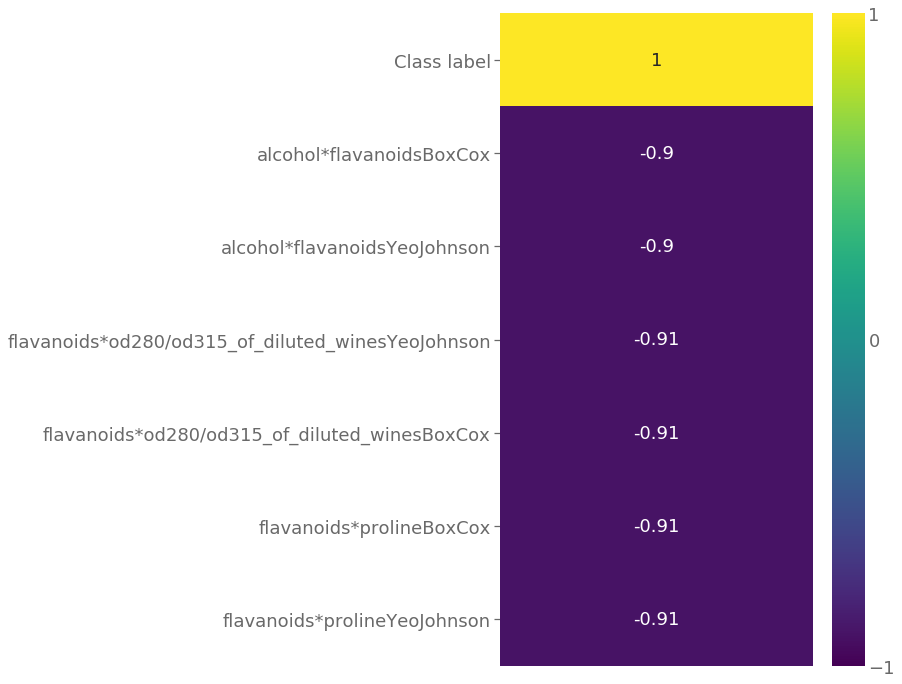

In [28]:
# correlation heat map with most highly correlated features relative to the target
p = PrettierPlot(plot_orientation='tall',chart_scale=10)
ax = p.make_canvas()
p.corr_heatmap_target(
    df=train.data,
    target=train.target,
    thresh=0.9,
    annot=True,
    ax=ax,
)

# Feature importance

<a id = 'Feature-importance'></a>

In [29]:
# generate feature importance summary
estimators = [
    lightgbm.LGBMClassifier,
    ensemble.RandomForestClassifier,
    ensemble.GradientBoostingClassifier,
    ensemble.ExtraTreesClassifier,
    ensemble.AdaBoostClassifier,
    xgboost.XGBClassifier,
]

fs = train.FeatureSelector(
    data=train.data,
    target=train.target,
    estimators=estimators,
)
feature_selector_summary = fs.feature_selector_suite(rank=True, n_jobs=16, save_to_csv=True)

In [33]:
# calculate cross-validation performance
estimators = [
    svm.SVC,
#     lightgbm.LGBMClassifier,
#     linear_model.LogisticRegression,
#     xgboost.XGBClassifier,
#     ensemble.RandomForestClassifier,
#     ensemble.GradientBoostingClassifier,
#     #ensemble.AdaBoostClassifier,
#     ensemble.ExtraTreesClassifier,
#     neighbors.KNeighborsClassifier,
]

cv_summary = fs.feature_selector_cross_val(
    feature_selector_summary=feature_selector_summary,
    scoring=["accuracy"],
    estimators=estimators,
    n_folds=5,
    n_jobs=16,
    step=1,
    save_to_csv=True,
)

In [34]:
cv_summary

,estimator,training score,validation score,scoring,features dropped
0,SVC,1.000000,0.978571,accuracy,0
1,SVC,1.000000,0.978571,accuracy,1
2,SVC,1.000000,0.978571,accuracy,2
3,SVC,1.000000,0.978571,accuracy,3
4,SVC,1.000000,0.978571,accuracy,4
5,SVC,1.000000,0.978571,accuracy,5
6,SVC,1.000000,0.978571,accuracy,6
7,SVC,1.000000,0.978571,accuracy,7
8,SVC,1.000000,0.978571,accuracy,8
9,SVC,1.000000,0.978571,accuracy,9


###### Accuracy

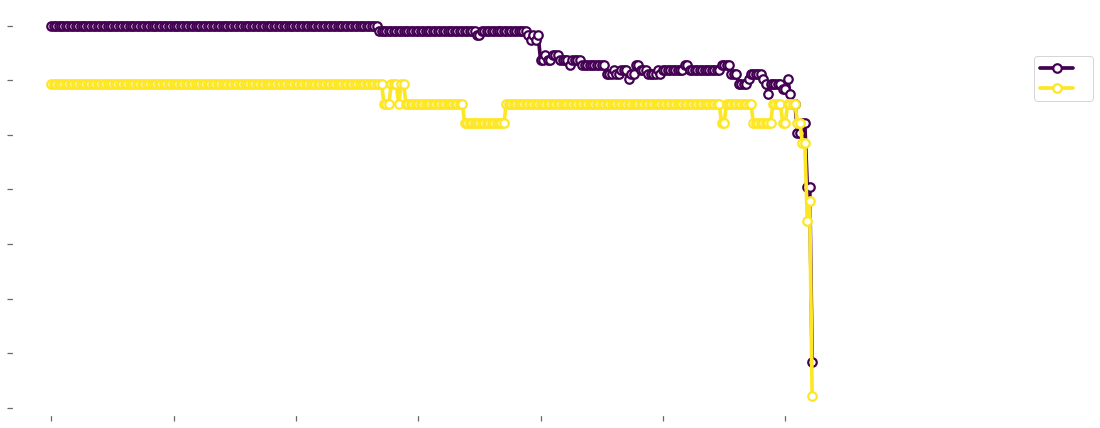

In [36]:
# visualize CV performance for diminishing feature set
fs.feature_selector_results_plot(
    cv_summary=cv_summary,
    feature_selector_summary=feature_selector_summary,
    scoring="accuracy",
    title_scale=0.8,
)

In [38]:
df = fs.create_cross_val_features_df(
    scoring="accuracy",
    cv_summary=cv_summary,
    feature_selector_summary=feature_selector_summary,
)
df

,feature,SVC,count
1,alcalinity_of_ash,x,1
2,alcalinity_of_ash*alcohol,x,1
3,alcalinity_of_ash*alcoholBoxCox,x,1
4,alcalinity_of_ash*alcoholYeoJohnson,x,1
5,alcalinity_of_ash*ash,x,1
6,alcalinity_of_ash*ashBoxCox,x,1
7,alcalinity_of_ash*ashYeoJohnson,x,1
8,alcalinity_of_ash*color_intensity,x,1
9,alcalinity_of_ash*color_intensityBoxCox,x,1
10,alcalinity_of_ash*color_intensityYeoJohnson,x,1


In [ ]:
# list feature that showed up in at least X models
df[df["count"] >= 7].index

# Modeling

<a id = 'Modeling'></a>

## Data preparation

<a id = 'Data-preparation-1'></a>

In [ ]:
#################################################################################
# import data
dataset = datasets.load_wine()
dataset = pd.merge(pd.DataFrame(dataset.data, columns=dataset.feature_names), pd.Series(dataset.target, name="Class label"), left_index=True, right_index=True)

# create training and validation datasets
df_train, df_valid = mlm.train_test_df_compile(data=dataset, target_col='Class label')

# load training data object
train = mlm.Machine(
    data=df_train,
    identify_as_continuous=['magnesium', 'proline'],
    target="Class label",
    target_type="category",
)

# load valid data object
valid = mlm.Machine(
    data=df_valid,
    identify_as_continuous=['magnesium', 'proline'],
    target="Class label",
)

#################################################################################
# feature transformation pipeline
# transform pipe
polynomial_pipe = PandasFeatureUnion([
    ("polynomial", pipeline.make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["continuous"]),
        PandasPipeline(preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    )),
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["continuous"], exclude_columns=["Name","Cabin"]),
    )),
])

train.data = polynomial_pipe.fit_transform(train.data)
valid.data = polynomial_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

# skew correction pipeline
skew_pipe = PandasFeatureUnion([
    ("skew", pipeline.make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["continuous"]),
        DualTransformer(),
    )),    
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["continuous"]),
    )),
])

train.data = skew_pipe.fit_transform(train.data)
valid.data = skew_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

#
scale_pipe = PandasFeatureUnion([
    ("scale", pipeline.make_pipeline(
        DataFrameSelector(),
        PandasPipeline(preprocessing.RobustScaler())
    )),
])

train.data = scale_pipe.fit_transform(train.data)
valid.data = scale_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()


#################################################################################
# remove outliers
outliers = np.array([59,121])
train.data = train.data.drop(outliers)
train.target = train.target.drop(index=outliers)

print("completed")

## Bayesian hyper-parameter optimization

<a id = 'Bayesian-hyper-parameter-optimization'></a>

In [ ]:
# model/parameter space
all_space = {
    "lightgbm.LGBMClassifier": {
        "class_weight": hp.choice("class_weight", [None, "balanced"]),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
        "boosting_type": hp.choice("boosting_type", ["gbdt", "dart", "goss"])
        # ,'boosting_type': hp.choice('boosting_type'
        #                    ,[{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}
        #                    ,{'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)}
        #                    ,{'boosting_type': 'goss', 'subsample': 1.0}])
        ,
        "learning_rate": hp.uniform("learning_rate", 0.000001, 0.2),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "min_child_samples": hp.uniform("min_child_samples", 20, 500),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 10, dtype=int)),
        "num_leaves": hp.uniform("num_leaves", 8, 150),
        "reg_alpha": hp.uniform("reg_alpha", 0.0, 1.0),
        "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
        "subsample_for_bin": hp.uniform("subsample_for_bin", 20000, 400000),
    },
    "linear_model.LogisticRegression": {
        "C": hp.loguniform("C", np.log(0.001), np.log(0.2)),
        "penalty": hp.choice("penalty", ["l1", "l2"]),
    },
    "xgboost.XGBClassifier": {
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
        "gamma": hp.uniform("gamma", 0.0, 10),
        "learning_rate": hp.uniform("learning_rate", 0.000001, 0.2),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "min_child_weight": hp.uniform("min_child_weight", 1, 20),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 10, dtype=int)),
        "subsample": hp.uniform("subsample", 0.5, 1),
    },
    "ensemble.RandomForestClassifier": {
        "bootstrap": hp.choice("bootstrap", [True, False]),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 10, dtype=int)),
        "max_features": hp.choice("max_features", ["auto", "sqrt"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
    },
    "ensemble.AdaBoostClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 10, dtype=int)),
        "learning_rate": hp.uniform("learning_rate", 0.000001, 0.2),
        "algorithm": hp.choice("algorithm", ["SAMME", "SAMME.R"]),
    },
    "ensemble.ExtraTreesClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 10, dtype=int)),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
        "max_features": hp.choice("max_features", ["auto", "sqrt"]),
        "criterion": hp.choice("criterion", ["gini", "entropy"]),
    },
    "svm.SVC": {
        "C": hp.uniform("C", 0.00001, 10),
        "decision_function_shape": hp.choice("decision_function_shape", ["ovo", "ovr"]),
        "gamma": hp.uniform("gamma", 0.00001, 10),
    },
    "neighbors.KNeighborsClassifier": {
        "algorithm": hp.choice("algorithm", ["auto", "ball_tree", "kd_tree", "brute"]),
        "n_neighbors": hp.choice("n_neighbors", np.arange(1, 20, dtype=int)),
        "weights": hp.choice("weights", ["distance", "uniform"]),
    },
}

In [ ]:
# execute bayesian optimization grid search
analysis = "wine"
train.exec_bayes_optim_search(
    all_space=all_space,
    results_dir="{}_hyperopt_{}.csv".format(rundate, analysis),
    X=train.data,
    y=train.target,
    scoring="accuracy",
    n_folds=2,
    n_jobs=3,
    iters=8,
    verbose=0,
)

##### Model loss by iteration

In [ ]:
# read scores summary table
analysis = "wine"
rundate = '20190808'
bayes_optim_summary = pd.read_csv("{}_hyperopt_{}.csv".format(rundate, analysis), na_values="nan")
bayes_optim_summary[:5]

In [ ]:
# model loss plot
for estimator in np.unique(bayes_optim_summary["estimator"]):
    train.model_loss_plot(bayes_optim_summary=bayes_optim_summary, estimator=estimator)

##### Parameter selection by iteration

In [ ]:
# estimator parameter plots
for estimator in np.unique(bayes_optim_summary['estimator']):
    train.modelParamPlot(bayes_optim_summary = bayes_optim_summary,
                         estimator=estimator,
                         all_space=all_space,
                         n_iter=100,
                         chart_scale=15)

In [ ]:
sample_space = {
                'param': hp.uniform('param', np.log(0.4), np.log(0.6))
#     "": 0.000001 + hp.uniform("gamma", 0.000001, 10)
    #             'param2': hp.loguniform('param2', np.log(0.001), np.log(0.01))
}

train.sample_plot(sample_space, 1000)

## Model performance evaluation - standard models

<a id = 'Model-performance-evaluation-standard-models'></a>

In [ ]:
top_models = train.top_bayes_optim_models(bayes_optim_summary=bayes_optim_summary, num_models=1)
top_models

In [ ]:
# classification panel, single model
estimator = "svm.SVC"; model_iter = 66
# estimator = 'ensemble.GradientBoostingClassifier'; model_iter = 590
# estimator = 'xgboost.XGBClassifier'; model_iter = 380

model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary, estimator=estimator, model_iter=model_iter
)

train.classification_panel(
    model=model, X_train=train.data, y_train=train.target, labels=[0, 1], n_folds=4
)

In [ ]:
# create classification reports
for estimator, model_iters in top_models.items():
    for model_iter in model_iters:
        model = train.BayesOptimModelBuilder(
            bayes_optim_summary=bayes_optim_summary,
            estimator=estimator,
            model_iter=model_iter,
        )
        train.classification_panel(
            model=model, X_train=train.data, y_train=train.target, labels=[0, 1], n_folds=4
        )

## Validation set evaluation - standard models

<a id = 'Validation-set-evaluation-standard-models'></a>

In [ ]:
## standard model fit and predict
# select estimator and iteration
# estimator = "lightgbm.LGBMClassifier"; model_iter = 476
estimator = "xgboost.XGBClassifier"; model_iter = 418
# estimator = "ensemble.RandomForestClassifier"; model_iter = 382
# estimator = "ensemble.GradientBoostingClassifier"; model_iter = 238
# estimator = "svm.SVC"; model_iter = 135

# extract params and instantiate model
model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary, estimator=estimator, model_iter=model_iter
)

# classification panel for validation data
train.classification_panel(
    model=model,
    X_train=train.data,
    y_train=train.target,
    X_valid=valid.data,
    y_valid=valid.target,
    labels=[0, 1],
)

In [ ]:
# create classification reports
for estimator, model_iters in top_models.items():
    for model_iter in model_iters:
        model = train.BayesOptimModelBuilder(
            bayes_optim_summary=bayes_optim_summary,
            estimator=estimator,
            model_iter=model_iter,
        )
        train.classification_panel(
            model=model,
            X_train=train.data,
            y_train=train.target,
            X_valid=valid.data,
            y_valid=valid.target,
            labels=[0, 1],
        )

## Model explanability

<a id = 'Feature-importance'></a>

In [ ]:
# 
estimator = "ensemble.ExtraTreesClassifier"; model_iter = 145

modelE = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary, estimator=estimator, model_iter=model_iter
)

modelE.fit(train.data.values, train.target.values)

##### Permutation importance

In [ ]:
# permutation importance - how much does performance decrease when shuffling a certain feature?
perm = PermutationImportance(modelR.model, random_state=1).fit(train.data, train.target)
eli5.show_weights(perm, feature_names=feature_names)

##### Partial plots

In [ ]:
for feature in feature_names:
    pdpFeature = pdp.pdp_isolate(
        model=modelR.model, dataset=train.data, model_features=feature_names, feature=feature
    )

    pdp.pdp_plot(pdpFeature, feature)
    plt.rcParams["axes.facecolor"] = "white"
    plt.rcParams["figure.facecolor"] = "white"

    plt.grid(b=None)
    plt.show()

##### SHAP values - training data

###### Force plots - single observations

In [ ]:
for i in np.arange(0, 4):
    train.single_shap_viz_tree(obsIx=i, model=modelR, data=train.data)

###### Force plots - multiple observations

In [ ]:
visual = train.multi_shap_viz_tree(obs_ixs=np.arange(0, 800), model=modelR, data=train.data)
visual

###### Dependence plots

In [ ]:
obs_data, _, obs_shap_values = train.multi_shap_value_tree(
    obs_ixs=np.arange(0, 800), model=modelR, data=train.data
)
train.shap_dependence_plot(
    obs_data=obs_data,
    obs_shap_values=obs_shap_values,
    scatter_feature="Fare",
    color_feature="Age",
    feature_names=train.data.columns.tolist(),
)

In [ ]:
obs_data, _, obs_shap_values = train.multi_shap_value_tree(
    obs_ixs=np.arange(0, 800), model=modelL, data=train.data
)
feature_names = train.data.columns.tolist()
top_shap = np.argsort(-np.sum(np.abs(obs_shap_values), 0))

# generate force plot
for top_ix in top_shap:
    train.shap_dependence_plot(
        obs_data=obs_data,
        obs_shap_values=obs_shap_values,
        scatter_feature=feature_names[top_ix],
        color_feature="Age",
        feature_names=feature_names,
    )

###### Summary plots

In [ ]:
obs_data, _, obs_shap_values = train.multi_shap_value_tree(
    obs_ixs=np.arange(0, 800), model=modelG, data=train.data
)
feature_names = train.data.columns.tolist()
train.shap_summary_plot(
        obs_data=obs_data,
        obs_shap_values=obs_shap_values,
        feature_names=feature_names,
    )

# Stacking

<a id = 'Stacking'></a>

## Primary models

<a id = 'Primary-models'></a>

In [ ]:
# get out-of-fold predictions
oof_train, oof_valid, columns = train.model_stacker(
    models=top_models,
    bayes_optim_summary=bayes_optim_summary,
    X_train=train.data.values,
    y_train=train.target.values,
    X_valid=valid.data.values,
    n_folds=10,
    n_jobs=10,
)

In [ ]:
# view correlations of predictions
p = PrettierPlot()
ax = p.make_canvas()
p.corr_heatmap(
    df=pd.DataFrame(oof_train, columns=columns), annot=True, ax=ax, vmin=0
)

## Meta model

<a id = 'Meta-model'></a>

In [ ]:
# parameter space
all_space = {
    "lightgbm.LGBMClassifier": {
        "class_weight": hp.choice("class_weight", [None]),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.7),
        "boosting_type": hp.choice("boosting_type", ["dart"]),
        "subsample": hp.uniform("subsample", 0.5, 1),
        "learning_rate": hp.uniform("learning_rate", 0.15, 0.25),
        "max_depth": hp.choice("max_depth", np.arange(4, 20, dtype=int)),
        "min_child_samples": hp.quniform("min_child_samples", 50, 150, 5),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "num_leaves": hp.quniform("num_leaves", 30, 70, 1),
        "reg_alpha": hp.uniform("reg_alpha", 0.75, 1.25),
        "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
        "subsample_for_bin": hp.quniform("subsample_for_bin", 100000, 350000, 20000),
    },
    "xgboost.XGBClassifier": {
        "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.7),
        "gamma": hp.quniform("gamma", 0.0, 10, 0.05),
        "learning_rate": hp.quniform("learning_rate", 0.01, 0.2, 0.01),
        "max_depth": hp.choice("max_depth", np.arange(2, 15, dtype=int)),
        "min_child_weight": hp.quniform("min_child_weight", 2.5, 7.5, 1),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "subsample": hp.uniform("subsample", 0.4, 0.7),
    },
    "ensemble.RandomForestClassifier": {
        "bootstrap": hp.choice("bootstrap", [True, False]),
        "max_depth": hp.choice("max_depth", np.arange(2, 10, dtype=int)),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 8000, 10, dtype=int)),
        "max_features": hp.choice("max_features", ["sqrt"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(15, 25, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 20, dtype=int)),
    },
    "ensemble.GradientBoostingClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "max_depth": hp.choice("max_depth", np.arange(2, 11, dtype=int)),
        "max_features": hp.choice("max_features", ["sqrt"]),
        "learning_rate": hp.quniform("learning_rate", 0.01, 0.09, 0.01),
        "loss": hp.choice("loss", ["deviance", "exponential"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
    },
    "svm.SVC": {
        "C": hp.uniform("C", 0.00000001, 15),
        "decision_function_shape": hp.choice("decision_function_shape", ["ovr", "ovo"]),
        "gamma": hp.uniform("gamma", 0.00000001, 1.5),
    },
}

In [ ]:
# execute bayesian optimization grid search
train.exec_bayes_optim_search(
    all_space=all_space,
    results_dir="{}_hyperopt_meta_{}.csv".format(rundate, analysis),
    X=oof_train,
    y=train.target,
    scoring="accuracy",
    n_folds=8,
    n_jobs=10,
    iters=1000,
    verbose=0,
)

In [ ]:
# read scores summary table
analysis = "wine"
rundate = "20190807"
bayes_optim_summary_meta = pd.read_csv("{}_hyperopt_meta_{}.csv".format(rundate, analysis))
bayes_optim_summary_meta[:5]

In [ ]:
# model loss plot
for estimator in np.unique(bayes_optim_summary_meta["estimator"]):
    train.model_loss_plot(bayes_optim_summary=bayes_optim_summary_meta, estimator=estimator)

In [ ]:
# estimator parameter plots
for estimator in np.unique(bayes_optim_summary_meta["estimator"]):
    train.modelParamPlot(
        bayes_optim_summary=bayes_optim_summary_meta,
        estimator=estimator,
        all_space=all_space,
        n_iter=100,
        chart_scale=15,
    )

## Model performance evaluation - stacked models

<a id = 'Model-performance-evaluation-stacked-models'></a>

In [ ]:
top_models = train.top_bayes_optim_models(
    bayes_optim_summary=bayes_optim_summary_meta, num_models=1
)
top_models

In [ ]:
# best second level learning model
estimator = "lightgbm.LGBMClassifier"; model_iter = 668
# estimator = "xgboost.XGBClassifier"; model_iter = 380
# estimator = "ensemble.RandomForestClassifier"; model_iter = 411
# estimator = "ensemble.GradientBoostingClassifier"; model_iter = 590
# estimator = "svm.SVC"; model_iter = 135

# extract params and instantiate model
model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary_meta, estimator=estimator, model_iter=model_iter
)
train.classification_panel(
    model=model, X_train=oof_train, y_train=train.target, labels=[0, 1]
)

In [ ]:
# create classification reports
for estimator, model_iters in top_models.items():
    for model_iter in model_iters:
        model = train.BayesOptimModelBuilder(
            bayes_optim_summary=bayes_optim_summary_meta,
            estimator=estimator,
            model_iter=model_iter,
        )
        train.classification_panel(
            model=model, X_train=oof_train, y_train=train.target, labels=[0, 1], n_folds=4
        )

## Validation set evaluation - stacked models

<a id = 'Validation-set-evaluation-stacked-models'></a>

In [ ]:
## standard model fit and predict
# select estimator and iteration
estimator = "lightgbm.LGBMClassifier"; model_iter = 668
# estimator = "xgboost.XGBClassifier"; model_iter = 380
# estimator = "ensemble.RandomForestClassifier"; model_iter = 411
# estimator = "ensemble.GradientBoostingClassifier"; model_iter = 590
# estimator = "svm.SVC"; model_iter = 135

# extract params and instantiate model
model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary_meta, estimator=estimator, model_iter=model_iter
)
model.fit(oof_train, train.target.values)

# fit model and make predictions
y_pred = model.predict(oof_valid)

In [ ]:
train.classification_panel(
    model=model,
    X_train=oof_train,
    y_train=train.target,
    X_valid=oof_valid,
    y_valid=valid.target,
    labels=[0, 1],
)

In [ ]:
# create classification reports
for estimator, model_iters in top_models.items():
    for model_iter in model_iters:
        model = train.BayesOptimModelBuilder(
            bayes_optim_summary=bayes_optim_summary_meta,
            estimator=estimator,
            model_iter=model_iter,
        )
        train.classification_panel(
            model=model,
            X_train=oof_train,
            y_train=train.target,
            X_valid=oof_valid,
            y_valid=valid.target,
            labels=[0, 1],
        )